In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
device = torch.device('cuda:0')
dtype = torch.float32
torch.backends.cudnn.benchmark = True

In [3]:
def read_all_image_folders(directories):
    images_075, images_300 = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                images_300.append(scale_image(image, 0.5))        
                images_075.append(scale_image(image, 0.25))
    return images_075, images_300

In [4]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [5]:
learning_rate = 0.001
batch_size = 16
epochs = 51

In [6]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.generator = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size = 7, stride = 1, padding = 3),
            nn.ReLU(),
            nn.ConvTranspose2d(30, 15, kernel_size = 7, stride = 2, padding = 3, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 9, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Sigmoid(),
#             nn.Conv2d(3, 60, kernel_size = 11, stride = 1, padding = 5),
#             nn.ReLU(),
#             nn.ConvTranspose2d(60, 30, kernel_size = 11, stride = 2, padding = 5, output_padding = 1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(30, 15, kernel_size = 9, stride = 1, padding = 4),
#             nn.ReLU(),
#             nn.ConvTranspose2d(15, 3, kernel_size = 5, stride = 1, padding = 2),
#             nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.generator(x)
        return x

In [7]:
model = generator().cuda()

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [9]:
def train(directories, epochs, batch_size):
    
    l_start = time.time()
    
    data_075, data_300 = read_all_image_folders(directories)
    x = torch.tensor(data_075, device = device, dtype = dtype)
    y = torch.tensor(data_300, device = device, dtype = dtype)
    del data_075, data_300
    
    print(f'Data loaded (m): {round((time.time() - l_start) / 60, 2)}')
    print('----------')
    
    loss_hist = []
    psnr_hist = []
    
    start = time.time()

    for t in range(epochs):
        for batch in range(0, int(x.shape[0]/batch_size)):
            
            batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
            batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
            outputs = model.forward(batch_x)

            loss = criterion(outputs, batch_y)
            psnr = 10 * math.log10(1 / F.mse_loss(outputs, batch_y))
            
            del batch_x, batch_y
            torch.cuda.empty_cache()
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % 1 == 0:
            loss_hist.append(loss.item())
            psnr_hist.append(psnr)
            print(t, f"PSNR: {psnr}, BCE: {loss.item()}, Time (m): {round((time.time() - start) / 60, 2)}")
            if psnr > 30:
                model.cpu()
                torch.save(model, f'../data/models/x4x2_{psnr}.pt')
                model.cuda()
            
    print('----------')
    print(f'Train Time (m): {round((time.time() - start) / 60, 2)}')
    
    plt.figure(1, figsize=(14,5))
    plt.subplot(1,2,1) 
    plt.title('PSNR')
    plt.plot(psnr_hist)
    plt.subplot(1,2,2)
    plt.title('BCE')
    plt.plot(loss_hist)
    plt.show()
    
    print(f'Memory allocated before clear: {torch.cuda.memory_cached()/1000**2} MB')
    del x, y
    torch.cuda.empty_cache()
    print(f'Memory allocated after clear: {torch.cuda.memory_cached()/1000**2} MB')
    
    return psnr

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Data loaded (m): 2.39
----------
0 PSNR: 24.118497853120907, BCE: 0.5343332290649414, Time (m): 0.18
1 PSNR: 25.824184978418778, BCE: 0.5313478708267212, Time (m): 0.35
2 PSNR: 25.505129325300672, BCE: 0.531498908996582, Time (m): 0.53
3 PSNR: 27.47210989338155, BCE: 0.5286427140235901, Time (m): 0.7
4 PSNR: 27.746991814205686, BCE: 0.5282257795333862, Time (m): 0.88
5 PSNR: 28.27253761899029, BCE: 0.5276689529418945, Time (m): 1.06
6 PSNR: 28.296343001923113, BCE: 0.5275647640228271, Time (m): 1.24
7 PSNR: 28.885133635280496, BCE: 0.5270431041717529, Time (m): 1.41
8 PSNR: 28.912124438575667, BCE: 0.5270186066627502, Time (m): 1.59
9 PSNR: 29.215297847201654, BCE: 0.5267316102981567, Time (m): 1.77
10 PSNR: 28.865414990440293, BCE: 0.5270018577575684, Time (m): 1.94
11 PSNR: 29.289679751811374, BCE: 0.5266537666320801, Time (m): 2.12
12 PSNR: 29.673033724248693, BCE: 0.5263820290565491, Time (m): 2.3
13 PSNR: 29.536566285882373, BCE: 0.5264593958854675, Time (m): 2.47
14 PSNR: 29.7287

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


17 PSNR: 30.092306899014794, BCE: 0.5260943174362183, Time (m): 3.18
18 PSNR: 30.163236913790573, BCE: 0.5260302424430847, Time (m): 3.35
19 PSNR: 30.176730685145316, BCE: 0.526009202003479, Time (m): 3.53
20 PSNR: 30.174830156971645, BCE: 0.5259958505630493, Time (m): 3.7
21 PSNR: 30.096603613398397, BCE: 0.5260577201843262, Time (m): 3.88
22 PSNR: 30.130242276997087, BCE: 0.5260197520256042, Time (m): 4.05
23 PSNR: 30.35497063777003, BCE: 0.5258865356445312, Time (m): 4.23
24 PSNR: 30.14774257273846, BCE: 0.5259739756584167, Time (m): 4.41
25 PSNR: 30.35416349993953, BCE: 0.5258508920669556, Time (m): 4.58
26 PSNR: 30.50255345647077, BCE: 0.5257867574691772, Time (m): 4.76
27 PSNR: 30.527012671565892, BCE: 0.5257812142372131, Time (m): 4.93
28 PSNR: 30.498447975378312, BCE: 0.5258059501647949, Time (m): 5.11
29 PSNR: 30.53589567957301, BCE: 0.5257852673530579, Time (m): 5.28
30 PSNR: 30.574230142482964, BCE: 0.5257587432861328, Time (m): 5.46
31 PSNR: 30.639564388382663, BCE: 0.52570

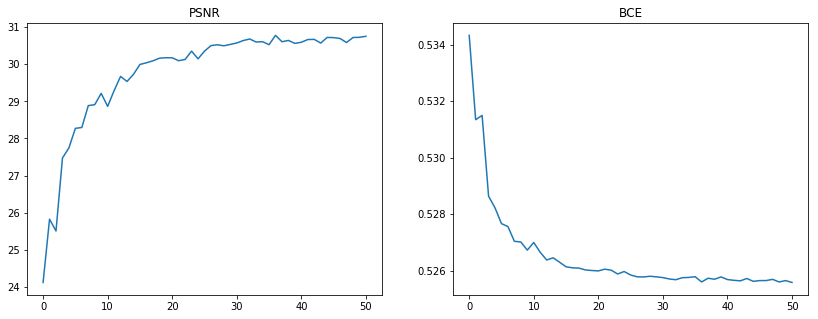

Memory allocated before clear: 1845.624832 MB
Memory allocated after clear: 5.373952 MB


In [10]:
psnr = train([0, 1, 2], epochs, batch_size)

Data loaded (m): 2.26
----------
0 PSNR: 31.11885438007111, BCE: 0.5303926467895508, Time (m): 0.17
1 PSNR: 31.1587460994299, BCE: 0.530372142791748, Time (m): 0.33
2 PSNR: 31.057508245417495, BCE: 0.5303992033004761, Time (m): 0.5
3 PSNR: 31.034250660603764, BCE: 0.5304268598556519, Time (m): 0.66
4 PSNR: 30.918176470612543, BCE: 0.530460000038147, Time (m): 0.83
5 PSNR: 30.996997309534354, BCE: 0.530413806438446, Time (m): 0.99
6 PSNR: 31.203165339854465, BCE: 0.5303266644477844, Time (m): 1.16
7 PSNR: 31.18368198963085, BCE: 0.5303326845169067, Time (m): 1.33
8 PSNR: 30.96025637745431, BCE: 0.5304349064826965, Time (m): 1.5
9 PSNR: 31.30685798897082, BCE: 0.5302782654762268, Time (m): 1.66
10 PSNR: 31.269527705890866, BCE: 0.5302885174751282, Time (m): 1.83
11 PSNR: 31.266331884262563, BCE: 0.5302823185920715, Time (m): 2.0
12 PSNR: 31.207403727544612, BCE: 0.530310869216919, Time (m): 2.17
13 PSNR: 31.252065361067327, BCE: 0.5302823781967163, Time (m): 2.33
14 PSNR: 31.329438813590

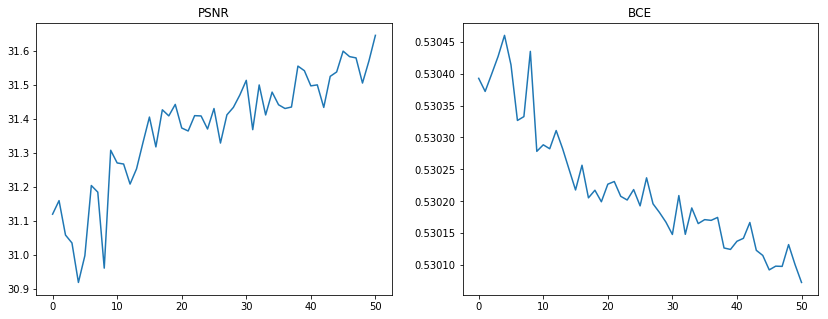

Memory allocated before clear: 1791.09888 MB
Memory allocated after clear: 5.373952 MB


In [11]:
psnr = train([3, 4, 5, 6], epochs, batch_size)

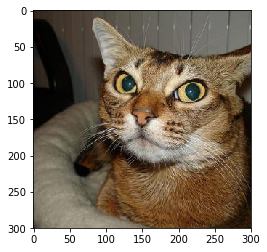

In [12]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
plt.imshow(image)
plt.show()

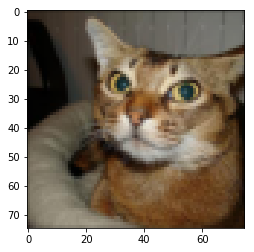

In [13]:
image_down = rescale(image=image, scale=0.25, multichannel=True, anti_aliasing=True)
plt.imshow(image_down)
plt.show()

In [14]:
image_up = model.forward(torch.tensor(image_down.reshape(1, 75, 75, 3), dtype = dtype, device = device).transpose(1, 3))

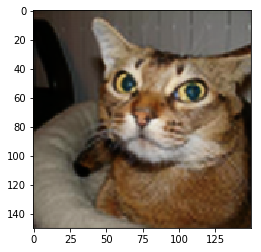

In [15]:
plt.imshow(image_up.transpose(1,3).cpu().detach().numpy().reshape(150, 150, 3))
plt.show()

In [16]:
torch.save(model.cpu(), f'../data/models/x4x2_F_{psnr}.pt')